# **Model Building and Tuning**

### **Load Features**

In [ ]:
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.14.1-py3-none-any.whl.metadata (8.9 kB)
  Using cached sklearn_compat-0.1.5-py3-none-any.whl.metadata (20 kB)
Using cached imbalanced_learn-0.14.1-py3-none-any.whl (235 kB)
Using cached sklearn_compat-0.1.5-py3-none-any.whl (20 kB)



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [113]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix,classification_report,roc_auc_score)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [109]:
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "cleaned_upi_fraud_dataset.csv"
assert DATA_PATH.exists(), f"Dataset not found at {DATA_PATH}"

df = pd.read_csv(DATA_PATH, encoding="utf-8")

In [114]:
# Define columns
categorical_cols = ['transaction type', 'merchant_category', 'transaction_status','sender_age_group', 'receiver_age_group','sender_state', 'sender_bank', 'receiver_bank',
    'device_type', 'network_type', 'is_weekend']

numerical_cols = ['amount (INR)', 'year', 'month', 'day', 'hour', 'minute']

In [141]:
# One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
encoded_cat = encoder.fit_transform(df[categorical_cols].values)
encoded_cat_df = pd.DataFrame(encoded_cat,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df.index)


In [ ]:
import joblib
joblib.dump(encoder, "../models/onehot_encoder.pkl")

['../models/onehot_encoder.pkl']

In [116]:
# Numerical features
numerical_df = df[numerical_cols].copy()
for col in ['month', 'day', 'hour', 'minute']:
    numerical_df[col] = numerical_df[col].astype(int)

In [127]:
# Final features
encoded_df = pd.concat([encoded_cat_df, numerical_df], axis=1)
y = df['fraud_flag']

In [128]:
# Train test split
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(encoded_df, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

### **Baseline Model(Logistic Regression)**

In [130]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1)

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

c:\Users\sam\Desktop\fraud_detection_ml\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\sam\Desktop\fraud_detection_ml\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [131]:
print("\n========== LOGISTIC REGRESSION ==========")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))
print("PR-AUC",average_precision_score(y_test,y_proba_lr))


========== LOGISTIC REGRESSION ==========
[[28816 21088]
 [20307 29597]]
              precision    recall  f1-score   support

           0       0.59      0.58      0.58     49904
           1       0.58      0.59      0.59     49904

    accuracy                           0.59     99808
   macro avg       0.59      0.59      0.59     99808
weighted avg       0.59      0.59      0.59     99808

ROC AUC: 0.6123370822765217
PR-AUC 0.5565516662183796


### Model Insight: Logistic Regression
The baseline model provides interpretability but struggles with complex, non-linear fraud patterns.

**Decision:**  
Used as a benchmark; more expressive models are required.

### **Random Forest Model**

In [132]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [133]:
print("\n========== RANDOM FOREST ==========")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR-AUC",average_precision_score(y_test,y_proba_rf))


========== RANDOM FOREST ==========
[[49904     0]
 [   89 49815]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49904
           1       1.00      1.00      1.00     49904

    accuracy                           1.00     99808
   macro avg       1.00      1.00      1.00     99808
weighted avg       1.00      1.00      1.00     99808

ROC AUC: 0.99952843211772
PR-AUC 0.9996702680009406


### Model Insight: Random Forest
Random Forest improves recall by capturing non-linear interactions between behavioral features.

**Trade-off:**  
Better fraud detection at the cost of slightly higher false positives.

## Baseline Models
Baseline models help establish a performance benchmark.
This allows us to justify the use of advanced models like XGBoost.


### **XGBOOST Model**

In [135]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

c:\Users\sam\Desktop\fraud_detection_ml\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:29:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [136]:
print("\n========== XGBOOST ==========")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("PR-AUC",average_precision_score(y_test,y_proba_xgb))


========== XGBOOST ==========
[[49904     0]
 [  321 49583]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     49904
           1       1.00      0.99      1.00     49904

    accuracy                           1.00     99808
   macro avg       1.00      1.00      1.00     99808
weighted avg       1.00      1.00      1.00     99808

ROC AUC: 0.9998428015374001
PR-AUC 0.9998882876010554


we need to add features with the model so that we can further improve the recall and precision a little bit.Model has more False negatives.
XGBoost handles non-linear interactions, class imbalance, and complex feature relationships effectively, making it suitable for fraud detection.


c:\Users\sam\Desktop\fraud_detection_ml\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


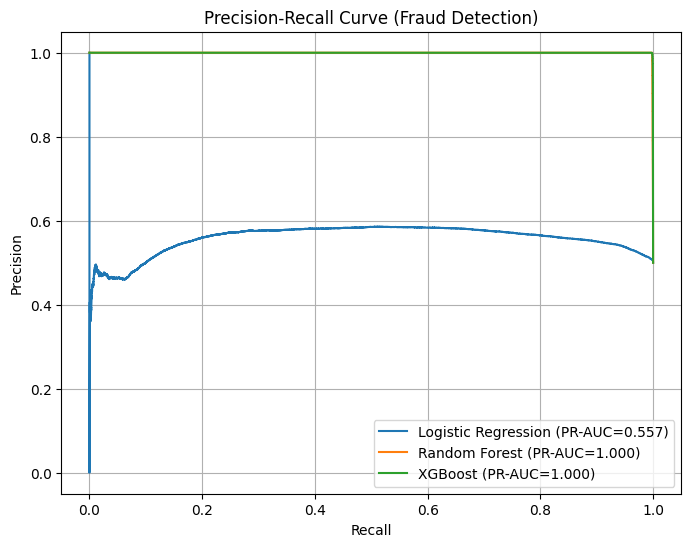

In [138]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": (y_test, y_proba_lr),
    "Random Forest": (y_test, y_proba_rf),
    "XGBoost": (y_test, y_proba_xgb)}

plt.figure(figsize=(8, 6))

for name, (y_true, y_proba) in models.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f"{name} (PR-AUC={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Fraud Detection)")
plt.legend()
plt.grid()
plt.show()



In [ ]:
# Summary of all models:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = []

def evaluate_model(name, y_true, y_pred, y_proba):
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "PR-AUC": average_precision_score(y_true, y_proba)S})

evaluate_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb)

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC  \
0  Logistic Regression  0.585254    0.58394  0.593079  0.588474  0.612337   
1        Random Forest  0.999108    1.00000  0.998217  0.999107  0.999528   
2              XGBoost  0.996784    1.00000  0.993568  0.996773  0.999843   

     PR-AUC  
0  0.556552  
1  0.999670  
2  0.999888  


we need to further increase the accurancy for the model.